In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as sklearn_auc
import matplotlib.pyplot as plt

df = pd.read_excel(r'..\data\metrics.xlsx', sheet_name='dataAll')

df[df['modality'] == "MURA"]['ML_LabelName'].unique()

ground_truth_benign_labels = ['BENIGN', 'BENIGN_WITHOUT_CALLBACK']
ground_truth_malignant_labels = ['MALIGNANT']

user_benign_labels = ['Normal', 'Benign', 'Probably Benign']
user_malignant_labels = ['Probably Malignant', 'Malignant']

ml_benign_labels = ['Normal', 'Benign', 'Probably Benign', ]
ml_malignant_labels = ['Probably Malignant', 'Malignant']


df.loc[df['GroundTruth'].isin(ground_truth_benign_labels), 'GroundTruth'] = "Normal"
df.loc[df['GroundTruth'].isin(ground_truth_malignant_labels), 'GroundTruth'] = "Malignant"

df.loc[df['UserAnnotatedLabel'].isin(user_benign_labels), 'UserAnnotatedLabel'] = "Normal"
df.loc[df['UserAnnotatedLabel'].isin(user_malignant_labels), 'UserAnnotatedLabel'] = "Malignant"

df.loc[df['ML_LabelName'].isin(ml_benign_labels), 'ML_LabelName'] = "Normal"
df.loc[df['ML_LabelName'].isin(ml_malignant_labels), 'ML_LabelName'] = "Malignant"

df = df.loc[~((df['GroundTruth'] == False) & (df['UserAnnotatedLabel'] == False) & (df['ML_LabelName'] == False))]
df = df.loc[~((df['GroundTruth'] == False) & (df['UserAnnotatedLabel'] == False) & (df['ML_LabelName'].isna()))]

df['UserCorrect'] = 0
df.loc[df['GroundTruth'] == df['UserAnnotatedLabel'], 'UserCorrect'] = 1

df['AiCorrect'] = 0
df.loc[df['GroundTruth'] == df['UserAnnotatedLabel'], 'UserCorrect'] = 1


# AUC ROC by modality
df_grouped = df.groupby(['modality', 'UserID', 'GroundTruth'])['UserCorrect'].mean().reset_index()


# df['GroundTruth'] = (df['GroundTruth'] == 'Pneumothorax').astype(int)
df_grouped.loc[df_grouped['GroundTruth'] == 'Pneumothorax', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'No Pneumothorax', 'GroundTruth'] = 0

df_grouped.loc[df_grouped['GroundTruth'] == 'Abnormal', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_grouped.loc[df_grouped['GroundTruth'] == 'Malignant', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_grouped = df_grouped[~(df_grouped['modality'] == 'CXR')]
df_grouped['GroundTruth'] = df_grouped['GroundTruth'].astype(int)

df_grouped.loc[df_grouped['GroundTruth'] == 0, 'UserCorrect'] = 1 - df_grouped.loc[df_grouped['GroundTruth'] == 0, 'UserCorrect']

#### AUC ROC by Modality

AUC for MURA: 1.00


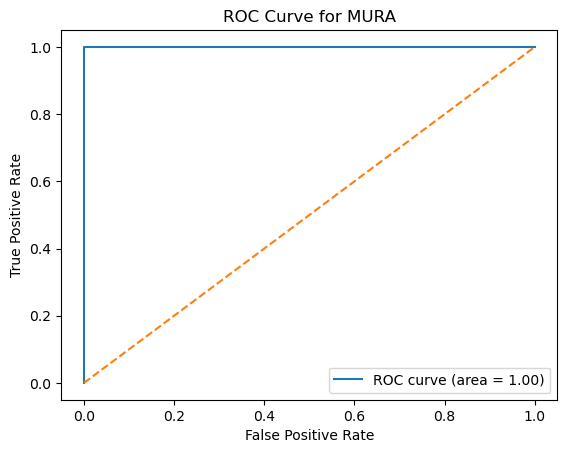

AUC for Mammography: 0.74


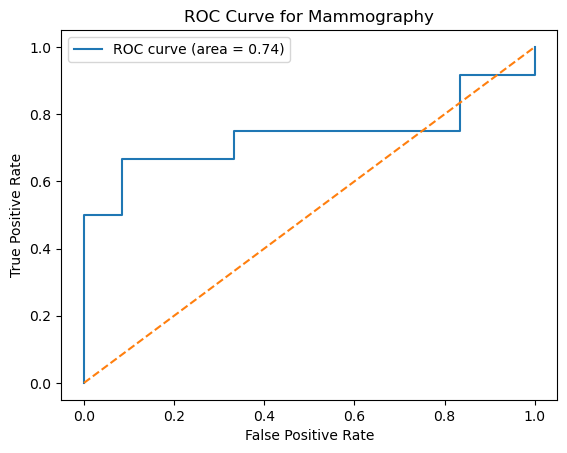

AUC for Pneumothorax: 1.00


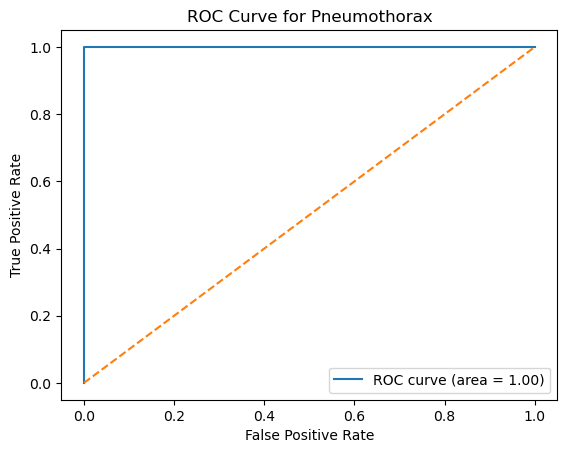

In [2]:
# Group by modality and calculate AUC on an overall
for modality, group in df_grouped.groupby('modality'):
    y_true = group['GroundTruth']
    y_scores = group['UserCorrect']
    auc = roc_auc_score(y_true, y_scores)

    # Output the AUC for each modality
    print(f"AUC for {modality}: {auc:.2f}")
    
    # If you want to plot the ROC Curve for each modality
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {modality}')
    plt.legend()
    plt.show()

#### AUC ROC by Modality and Phase type

In [3]:
# AUC ROC by modality and type (AI, Normal)
df_grouped = df.groupby(['modality', 'UserID', 'type', 'GroundTruth'])['UserCorrect'].mean().reset_index()

# df['GroundTruth'] = (df['GroundTruth'] == 'Pneumothorax').astype(int)
df_grouped.loc[df_grouped['GroundTruth'] == 'Pneumothorax', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'No Pneumothorax', 'GroundTruth'] = 0

df_grouped.loc[df_grouped['GroundTruth'] == 'Abnormal', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_grouped.loc[df_grouped['GroundTruth'] == 'Malignant', 'GroundTruth'] = 1
df_grouped.loc[df_grouped['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_grouped = df_grouped[~(df_grouped['modality'] == 'CXR')]
df_grouped['GroundTruth'] = df_grouped['GroundTruth'].astype(int)

df_grouped.loc[df_grouped['GroundTruth'] == 0, 'UserCorrect'] = 1 - df_grouped.loc[df_grouped['GroundTruth'] == 0, 'UserCorrect']

AUC for ('MURA', 'Human'): 0.92


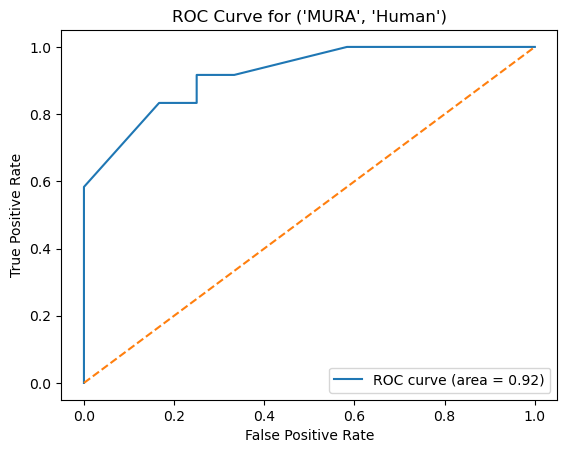

AUC for ('MURA', 'Human_AI'): 1.00


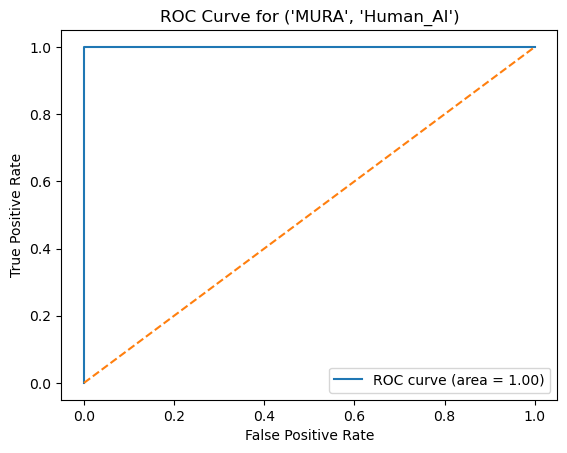

AUC for ('Mammography', 'Human'): 0.63


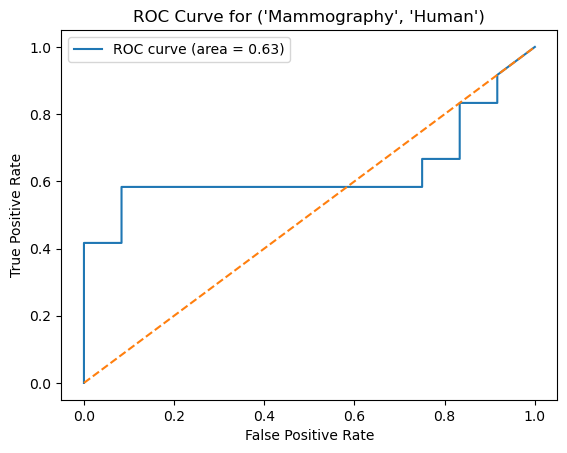

AUC for ('Mammography', 'Human_AI'): 0.67


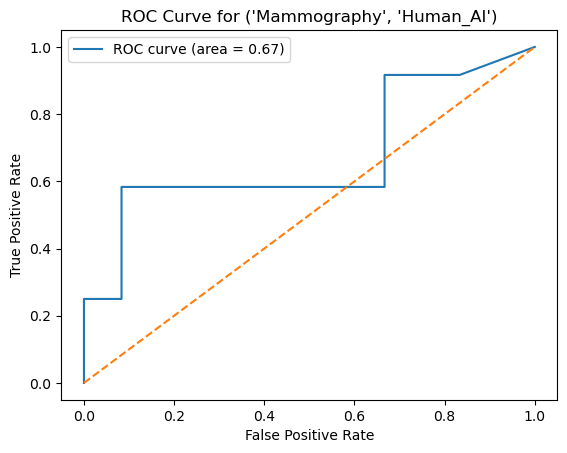

AUC for ('Pneumothorax', 'Human'): 0.99


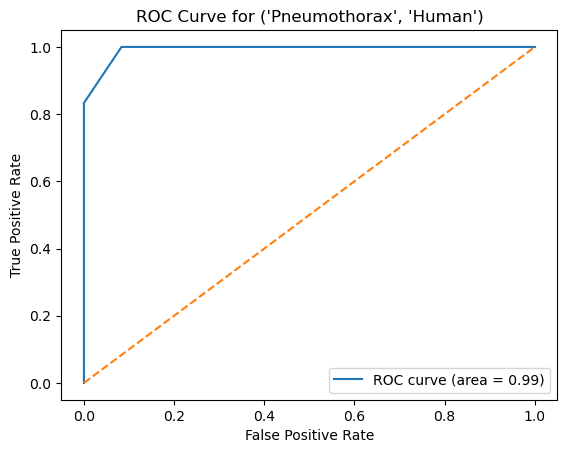

AUC for ('Pneumothorax', 'Human_AI'): 1.00


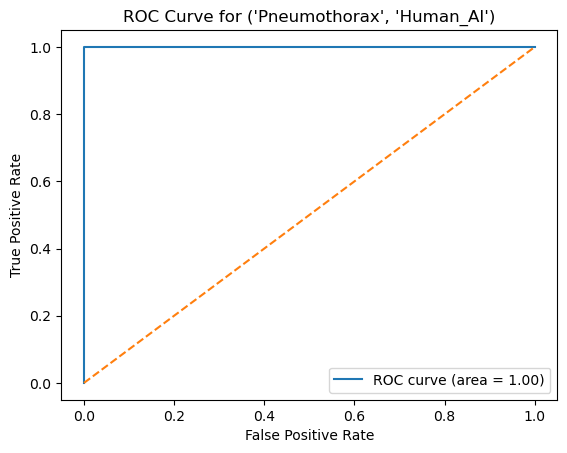

In [4]:
# Group by modality and calculate AUC for each group
for modality, group in df_grouped.groupby(['modality', 'type']):
    y_true = group['GroundTruth']
    y_scores = group['UserCorrect']
    auc = roc_auc_score(y_true, y_scores)

    # Output the AUC for each modality
    print(f"AUC for {modality}: {auc:.2f}")
    
    # If you want to plot the ROC Curve for each modality
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {modality}')
    plt.legend()
    plt.show()

#### AUC ROC by Modality - AI Only

In [5]:
# AUC ROC AI only
df_ai = df[~df['modality'].isin(["CXR"])]
df_ai = df_ai[df_ai['type'] == "Human_AI"]

df_ai.loc[df_ai['GroundTruth'] == 'Abnormal', 'GroundTruth'] = 1
df_ai.loc[df_ai['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_ai.loc[df_ai['GroundTruth'] == 'Malignant', 'GroundTruth'] = 1
df_ai.loc[df_ai['GroundTruth'] == 'Normal', 'GroundTruth'] = 0

df_ai.loc[df_ai['GroundTruth'] == 'Pneumothorax', 'GroundTruth'] = 1
df_ai.loc[df_ai['GroundTruth'] == 'No Pneumothorax', 'GroundTruth'] = 0

# reverse probability for MURA - abnormal
df_ai.loc[(df_ai['ML_LabelName'] == 'Normal') & (df_ai['modality'] == 'MURA'), 'ML_probability'] = 1 - df_ai.loc[(df_ai['ML_LabelName'] == 'Normal') & (df_ai['modality'] == 'MURA'), 'ML_probability']
df_ai.loc[(df_ai['ML_LabelName'] == 'No Pneumothorax') & (df_ai['modality'] == 'Pneumothorax'), 'ML_probability'] = 1 - df_ai.loc[(df_ai['ML_LabelName'] == 'No Pneumothorax') & (df_ai['modality'] == 'Pneumothorax'), 'ML_probability']


AUC for MURA: 0.89


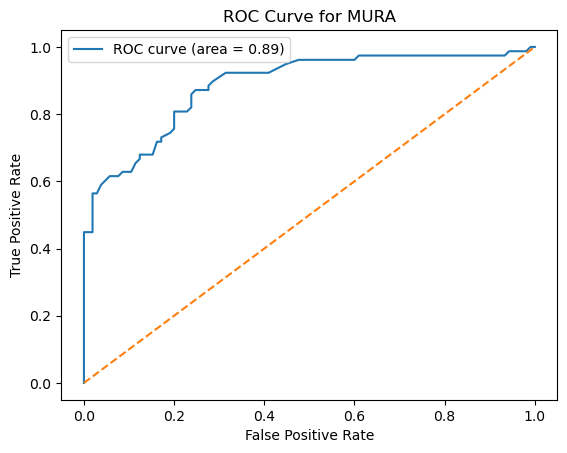

AUC for Mammography: 0.67


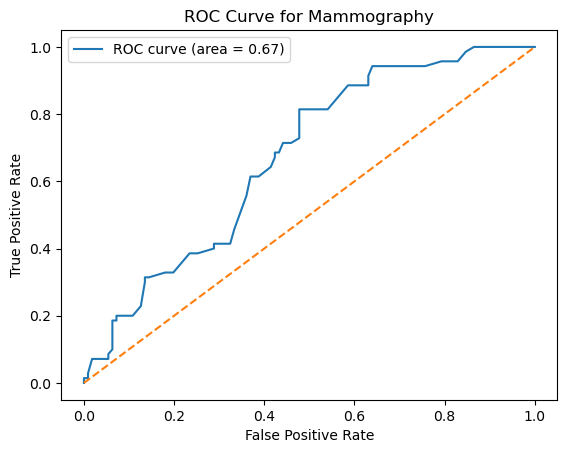

AUC for Pneumothorax: 0.83


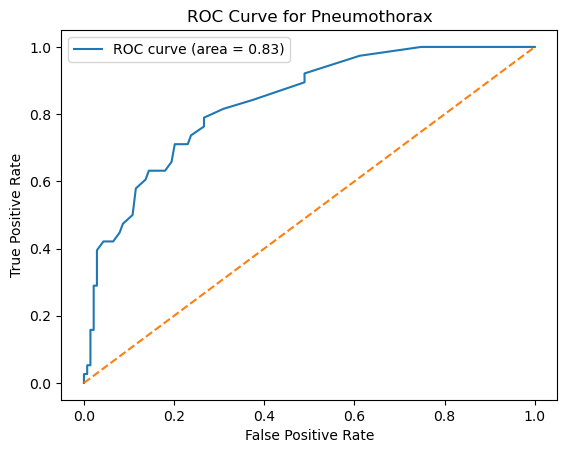

In [6]:
df_ai['GroundTruth'] = df_ai['GroundTruth'].astype(int)
# Group by modality and calculate AUC for each group
for modality, group in df_ai.groupby('modality'):
    y_true = group['GroundTruth']
    y_scores = group['ML_probability']
    auc = roc_auc_score(y_true, y_scores)

    # Output the AUC for each modality
    print(f"AUC for {modality}: {auc:.2f}")
    
    # If you want to plot the ROC Curve for each modality
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {modality}')
    plt.legend()
    plt.show()

#### AUC ROC for CXR

#### Non AI

In [8]:
# Metrics for CXR
cxr_normal = pd.read_csv(r'..\data\Normal\cxr_postprocess\cxr_postprocess_normal.csv')
cxr_ai = pd.read_csv(r'..\data\AI\cxr_postprocess\cxr_postprocess_ai.csv')

cxr_normal.loc[cxr_normal['Truth'] != "FALSE", 'Truth'] = 1
cxr_normal.loc[cxr_normal['Truth'] == "FALSE", 'Truth'] = 0
cxr_normal.loc[cxr_normal['User'] != "FALSE", 'User'] = 1
cxr_normal.loc[cxr_normal['User'] == "FALSE", 'User'] = 0


cxr_ai.loc[cxr_ai['Truth'] != "FALSE", 'Truth'] = 1
cxr_ai.loc[cxr_ai['Truth'] == "FALSE", 'Truth'] = 0
cxr_ai.loc[cxr_ai['User'] != "FALSE", 'User'] = 1
cxr_ai.loc[cxr_ai['User'] == "FALSE", 'User'] = 0
cxr_ai.loc[cxr_ai['ML'] != "FALSE", 'ML'] = 1
cxr_ai.loc[cxr_ai['ML'] == "FALSE", 'ML'] = 0


# CXR Normal
cxr_normal['UserCorrect'] = 0
cxr_normal.loc[cxr_normal['Truth'] > 1, 'Truth'] = 1
cxr_normal.loc[cxr_normal['Truth'] == cxr_normal['User'], 'UserCorrect'] = 1


cxr_normal_grouped = cxr_normal.groupby(['variable', 'updatedById', 'Truth'])['UserCorrect'].mean().reset_index()
cxr_normal_grouped.loc[cxr_normal_grouped['Truth'] == 0, 'UserCorrect'] = 1 - cxr_normal_grouped.loc[cxr_normal_grouped['Truth'] == 0, 'UserCorrect']

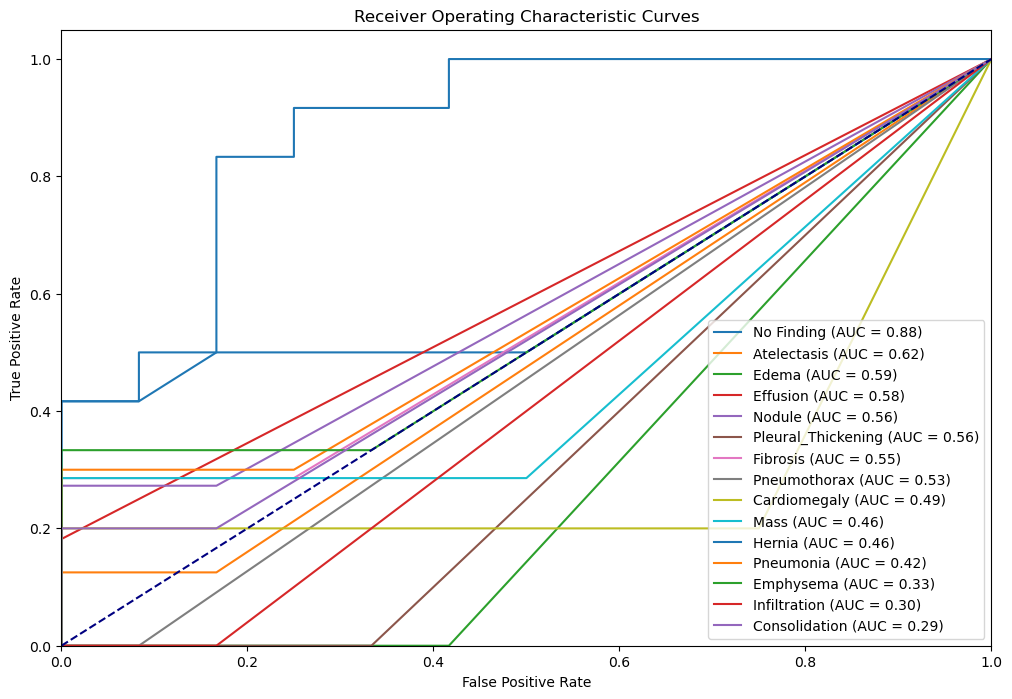

In [9]:
plt.figure(figsize=(12, 8))

types = cxr_normal_grouped['variable'].unique()

# Step 1: Store AUC and Labels
auc_labels = []

for type_ in types:
    df_type = cxr_normal_grouped[cxr_normal_grouped['variable'] == type_]
    fpr, tpr, thresholds = roc_curve(df_type['Truth'], df_type['UserCorrect'])
    roc_auc = sklearn_auc(fpr, tpr)  
    # Creating a label for each line and store it with its AUC
    label = f'{type_} (AUC = {roc_auc:.2f})'
    auc_labels.append((roc_auc, label))
    plt.plot(fpr, tpr)

# Step 2: Sort AUC and Labels
auc_labels = sorted(auc_labels, key=lambda x: x[0], reverse=True)  

# Step 3: Add Labels to Legend
plt.legend([label for _, label in auc_labels], loc='lower right')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')

plt.show()

#### AI Assisted

C:\Users\rohan\anaconda3\envs\plhilab\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\rohan\anaconda3\envs\plhilab\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


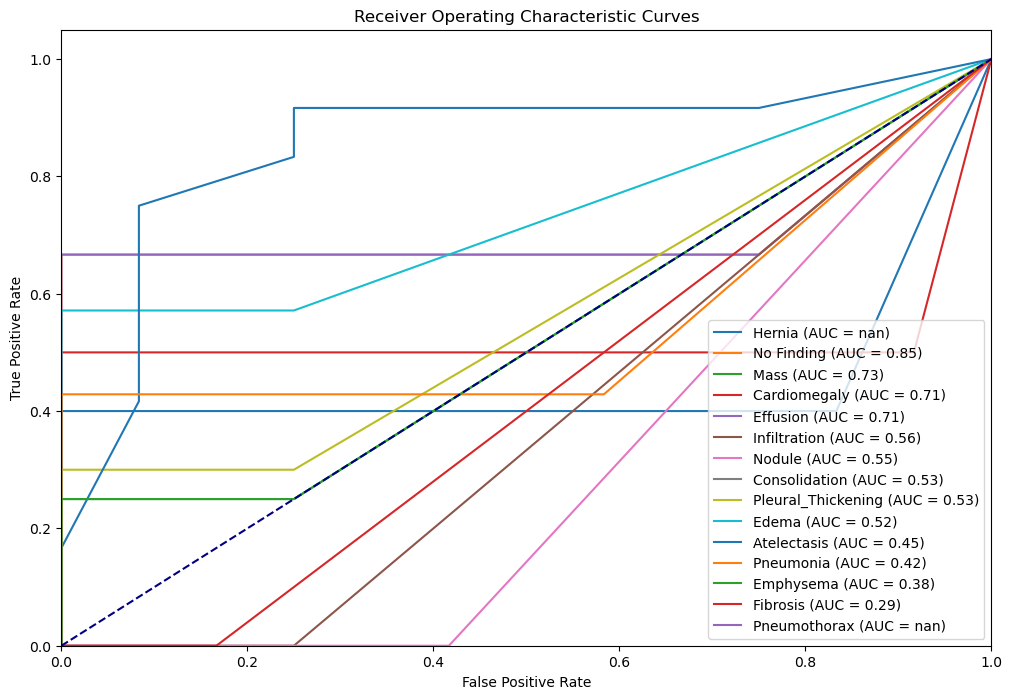

In [10]:
### CXR AI ###
cxr_ai['UserCorrect'] = 0
cxr_ai.loc[cxr_ai['Truth'] > 1, 'Truth'] = 1
cxr_ai.loc[cxr_ai['Truth'] == cxr_ai['User'], 'UserCorrect'] = 1


cxr_ai_grouped = cxr_ai.groupby(['variable', 'updatedById', 'Truth'])['UserCorrect'].mean().reset_index()
cxr_ai_grouped.loc[cxr_ai_grouped['Truth'] == 0, 'UserCorrect'] = 1 - cxr_ai_grouped.loc[cxr_ai_grouped['Truth'] == 0, 'UserCorrect']


plt.figure(figsize=(12, 8))

types = cxr_ai_grouped['variable'].unique()

# Step 1: Store AUC and Labels
auc_labels = []

for type_ in types:
    df_type = cxr_ai_grouped[cxr_ai_grouped['variable'] == type_]
    fpr, tpr, thresholds = roc_curve(df_type['Truth'], df_type['UserCorrect'])
    roc_auc = sklearn_auc(fpr, tpr)  
    # Creating a label for each line and store it with its AUC
    label = f'{type_} (AUC = {roc_auc:.2f})'
    auc_labels.append((roc_auc, label))
    plt.plot(fpr, tpr)

# Step 2: Sort AUC and Labels
auc_labels = sorted(auc_labels, key=lambda x: x[0], reverse=True)  

# Step 3: Add Labels to Legend
plt.legend([label for _, label in auc_labels], loc='lower right')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')

plt.show()

#### CXR - Non-AI, AI Assisted, AI Only

In [11]:
############ AUC TABLE ###########

from sklearn.metrics import roc_curve, auc
import pandas as pd

def compute_auc(df_grouped, types):
    auc_dict = {}
    for type_ in types:
        df_type = df_grouped[df_grouped['variable'] == type_]
        fpr, tpr, thresholds = roc_curve(df_type['Truth'], df_type['UserCorrect'])
        roc_auc = auc(fpr, tpr)
        auc_dict[type_] = roc_auc
    return auc_dict

# Assuming `cxr_normal_grouped` and `cxr_ai_grouped` have been prepared as per your provided code...

types_normal = cxr_normal_grouped['variable'].unique()
types_ai = cxr_ai_grouped['variable'].unique()

auc_normal = compute_auc(cxr_normal_grouped, types_normal)
auc_ai = compute_auc(cxr_ai_grouped, types_ai)

df_auc_normal = pd.DataFrame(list(auc_normal.items()), columns=['Label', 'AUC Non AI'])
df_auc_ai = pd.DataFrame(list(auc_ai.items()), columns=['Label', 'AUC AI Assisted'])

# Merging two dataframes based on Label
df_auc = pd.merge(df_auc_normal, df_auc_ai, on='Label', how='outer')

print(df_auc)

                 Label  AUC Non AI  AUC AI Assisted
0          Atelectasis    0.618056         0.450000
1         Cardiomegaly    0.489583         0.708333
2        Consolidation    0.291667         0.531250
3                Edema    0.590909         0.520833
4             Effusion    0.575758         0.708333
5            Emphysema    0.333333         0.375000
6             Fibrosis    0.553571         0.291667
7               Hernia    0.458333              NaN
8         Infiltration    0.300000         0.562500
9                 Mass    0.464286         0.732143
10          No Finding    0.878472         0.854167
11              Nodule    0.562500         0.547619
12  Pleural_Thickening    0.555556         0.531250
13           Pneumonia    0.416667         0.416667
14        Pneumothorax    0.533333              NaN


C:\Users\rohan\anaconda3\envs\plhilab\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\rohan\anaconda3\envs\plhilab\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [13]:
############ AI ONLY AUC ROC ###########

# Getting unique label names
labels = cxr_ai['variable'].unique()

# Initialize a dictionary to store your AUC scores
auc_scores = {}

# Loop over each unique label
for label in labels:
    # Filter the DataFrame for the current label
    df_label = cxr_ai[cxr_ai['variable'] == label]
    
    # Ensure that you have both positive and negative samples to compute AUC
    if len(df_label['Truth'].unique()) > 1:
        # Calculate AUC score and store it in the dictionary
        auc_scores[label] = roc_auc_score(df_label['Truth'].astype(int), df_label['ML Prob'])
    else:
        auc_scores[label] = float('nan')  # Assign NaN if AUC can't be computed (i.e., only one class present)

# Convert your AUC scores into a DataFrame
df_auc_ml = pd.DataFrame(list(auc_scores.items()), columns=['Label', 'AUC ML'])

In [14]:
print(df_auc_ml)

                 Label    AUC ML
0          Atelectasis  0.885965
1         Cardiomegaly  0.867775
2        Consolidation  0.872832
3                Edema  0.742857
4             Effusion  0.866733
5            Emphysema  0.494253
6             Fibrosis  0.731429
7               Hernia       NaN
8         Infiltration  0.615256
9                 Mass  0.919328
10          No Finding  0.782030
11              Nodule  0.776266
12  Pleural_Thickening  0.471098
13           Pneumonia  0.500000
14        Pneumothorax       NaN
